# Modelo de Classificação - Previsão de Atrasos em Voos

Este notebook apresenta a modelagem supervisionada para classificação de atrasos em voos.

**Objetivo:** Prever se um voo terá atraso significativo (> 15 minutos) na partida.

**Modelos avaliados:**
- Logistic Regression
- Random Forest Classifier
- Gradient Boosting Classifier

---

## 1. Configuração e Importações

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, roc_auc_score, confusion_matrix, 
    classification_report, roc_curve
)
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

os.makedirs('../models', exist_ok=True)

print("Bibliotecas carregadas com sucesso!")

Bibliotecas carregadas com sucesso!


## 2. Carregamento dos Dados

In [ ]:
df_flights = pd.read_csv('../data/flights_clean.csv')

print(f"Dados carregados: {df_flights.shape[0]:,} registros, {df_flights.shape[1]} colunas")
print(f"\nColunas disponíveis:")
print(df_flights.columns.tolist())

Dados carregados: 5,819,079 registros, 31 colunas

Colunas disponíveis:
['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER', 'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']


## 3. Preparação dos Dados

In [ ]:
df = df_flights[df_flights['CANCELLED'] == 0].copy()
print(f"Voos não cancelados: {df.shape[0]:,}")

df['TARGET'] = (df['DEPARTURE_DELAY'] > 15).astype(int)

print(f"\nDistribuição da variável target:")
print(df['TARGET'].value_counts())
print(f"\nProporção:")
print(df['TARGET'].value_counts(normalize=True).round(4))

Voos não cancelados: 5,729,195

Distribuição da variável target:
TARGET
0    4712659
1    1016536
Name: count, dtype: int64

Proporção:
TARGET
0    0.8226
1    0.1774
Name: proportion, dtype: float64


In [ ]:
cols_leakage = [
    'YEAR', 'DAY', 'FLIGHT_NUMBER', 'TAIL_NUMBER',
    'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF',
    'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME',
    'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL',
    'ARRIVAL_TIME', 'ARRIVAL_DELAY',
    'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
    'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
    'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'
]

df = df.drop(columns=[col for col in cols_leakage if col in df.columns])
print(f"Colunas após remoção de leakage: {df.shape[1]}")
print(df.columns.tolist())

Colunas após remoção de leakage: 8
['MONTH', 'DAY_OF_WEEK', 'AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DISTANCE', 'TARGET']


## 4. Feature Engineering

In [ ]:
df['HOUR'] = (df['SCHEDULED_DEPARTURE'] // 100).clip(0, 23)

def get_period(hour):
    if 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 18:
        return 'afternoon'
    elif 18 <= hour < 24:
        return 'evening'
    else:
        return 'night'

df['PERIOD_OF_DAY'] = df['HOUR'].apply(get_period)

df['IS_WEEKEND'] = (df['DAY_OF_WEEK'].isin([6, 7])).astype(int)

df['MONTH_SIN'] = np.sin(2 * np.pi * df['MONTH'] / 12)
df['MONTH_COS'] = np.cos(2 * np.pi * df['MONTH'] / 12)
df['DAY_SIN'] = np.sin(2 * np.pi * df['DAY_OF_WEEK'] / 7)
df['DAY_COS'] = np.cos(2 * np.pi * df['DAY_OF_WEEK'] / 7)


origin_delay = df.groupby('ORIGIN_AIRPORT')['TARGET'].mean().to_dict()
df['ORIGIN_DELAY_RATE'] = df['ORIGIN_AIRPORT'].map(origin_delay)


origin_volume = df['ORIGIN_AIRPORT'].value_counts().to_dict()
df['ORIGIN_VOLUME'] = df['ORIGIN_AIRPORT'].map(origin_volume)

airline_delay = df.groupby('AIRLINE')['TARGET'].mean().to_dict()
df['AIRLINE_DELAY_RATE'] = df['AIRLINE'].map(airline_delay)

df = df.drop(columns=['SCHEDULED_DEPARTURE'])

print(f"Features criadas. Shape atual: {df.shape}")

Features criadas. Shape atual: (5729195, 17)


## 5. Encoding de Variáveis Categóricas

In [ ]:
df['ORIGIN_AIRPORT'] = df['ORIGIN_AIRPORT'].astype(str)
df['DESTINATION_AIRPORT'] = df['DESTINATION_AIRPORT'].astype(str)

le_airline = LabelEncoder()
df['AIRLINE_ENCODED'] = le_airline.fit_transform(df['AIRLINE'])


le_origin = LabelEncoder()
df['ORIGIN_ENCODED'] = le_origin.fit_transform(df['ORIGIN_AIRPORT'])

le_dest = LabelEncoder()
df['DEST_ENCODED'] = le_dest.fit_transform(df['DESTINATION_AIRPORT'])

origin_freq = df['ORIGIN_AIRPORT'].value_counts(normalize=True).to_dict()
df['ORIGIN_FREQ'] = df['ORIGIN_AIRPORT'].map(origin_freq)

dest_freq = df['DESTINATION_AIRPORT'].value_counts(normalize=True).to_dict()
df['DEST_FREQ'] = df['DESTINATION_AIRPORT'].map(dest_freq)

df = pd.get_dummies(df, columns=['PERIOD_OF_DAY'], prefix='PERIOD', drop_first=True)

df = df.drop(columns=['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT'])

print(f"Encoding completo. Shape final: {df.shape}")
print(f"\nColunas finais:")
print(df.columns.tolist())

Encoding completo. Shape final: (5729195, 21)

Colunas finais:
['MONTH', 'DAY_OF_WEEK', 'DISTANCE', 'TARGET', 'HOUR', 'IS_WEEKEND', 'MONTH_SIN', 'MONTH_COS', 'DAY_SIN', 'DAY_COS', 'ORIGIN_DELAY_RATE', 'ORIGIN_VOLUME', 'AIRLINE_DELAY_RATE', 'AIRLINE_ENCODED', 'ORIGIN_ENCODED', 'DEST_ENCODED', 'ORIGIN_FREQ', 'DEST_FREQ', 'PERIOD_evening', 'PERIOD_morning', 'PERIOD_night']


## 6. Tratamento de Missing Values

In [ ]:
missing = df.isnull().sum()
missing = missing[missing > 0]

if len(missing) > 0:
    print(f"Colunas com missing values:")
    print(missing)
    df = df.dropna()
    print(f"\nApós remoção: {df.shape[0]:,} registros")
else:
    print("Sem missing values.")

Sem missing values.


## 7. Divisão dos Dados

In [ ]:
X = df.drop(columns=['TARGET'])
y = df['TARGET']

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp
)

print(f"Divisão dos dados:")
print(f"  - Treino:     {X_train.shape[0]:,} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  - Validação:  {X_val.shape[0]:,} ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"  - Teste:      {X_test.shape[0]:,} ({X_test.shape[0]/len(X)*100:.1f}%)")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

joblib.dump(scaler, '../models/scaler.pkl')
joblib.dump(list(X.columns), '../models/feature_names.pkl')

print(f"\nNormalização aplicada.")
print(f"Scaler salvo em: ../models/scaler.pkl")
print(f"Features salvas em: ../models/feature_names.pkl")

Divisão dos dados:
  - Treino:     4,012,727 (70.0%)
  - Validação:  857,088 (15.0%)
  - Teste:      859,380 (15.0%)

Normalização aplicada.
Scaler salvo em: ../models/scaler.pkl
Features salvas em: ../models/feature_names.pkl


## 8. Treinamento dos Modelos

### 8.1 Logistic Regression

In [ ]:
param_grid_lr = {
    'C': [0.01, 0.1, 1.0],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
    'class_weight': ['balanced', None]
}

print("Treinando Logistic Regression com GridSearchCV...")
lr_base = LogisticRegression(max_iter=1000, random_state=42)

grid_search_lr = GridSearchCV(
    lr_base, param_grid_lr,
    cv=5, scoring='f1', n_jobs=-1, verbose=1
)
grid_search_lr.fit(X_train_scaled, y_train)

print(f"\nMelhores parâmetros: {grid_search_lr.best_params_}")
print(f"Melhor F1-Score (CV): {grid_search_lr.best_score_:.4f}")

lr_best = grid_search_lr.best_estimator_

# Salvar modelo
joblib.dump(lr_best, '../models/logistic_regression_best.pkl')

Treinando Logistic Regression com GridSearchCV...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Melhores parâmetros: {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}
Melhor F1-Score (CV): 0.3637


['../models/logistic_regression_best.pkl']

### 8.2 Random Forest Classifier

In [ ]:
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [5, 10],
    'class_weight': ['balanced', None]
}

print("Treinando Random Forest com GridSearchCV...")
rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)

grid_search_rf = GridSearchCV(
    rf_base, param_grid_rf,
    cv=3, scoring='f1', n_jobs=-1, verbose=1
)
grid_search_rf.fit(X_train_scaled, y_train)

print(f"\nMelhores parâmetros: {grid_search_rf.best_params_}")
print(f"Melhor F1-Score (CV): {grid_search_rf.best_score_:.4f}")

rf_best = grid_search_rf.best_estimator_

joblib.dump(rf_best, '../models/random_forest_best.pkl')

Treinando Random Forest com GridSearchCV...
Fitting 3 folds for each of 24 candidates, totalling 72 fits

Melhores parâmetros: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}
Melhor F1-Score (CV): 0.3880


['../models/random_forest_best.pkl']

### 8.3 Gradient Boosting Classifier

In [ ]:
param_grid_gb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'min_samples_split': [5, 10]
}

print("Treinando Gradient Boosting com GridSearchCV...")
gb_base = GradientBoostingClassifier(random_state=42)

grid_search_gb = GridSearchCV(
    gb_base, param_grid_gb,
    cv=3, scoring='f1', n_jobs=-1, verbose=1
)
grid_search_gb.fit(X_train_scaled, y_train)

print(f"\nMelhores parâmetros: {grid_search_gb.best_params_}")
print(f"Melhor F1-Score (CV): {grid_search_gb.best_score_:.4f}")

gb_best = grid_search_gb.best_estimator_

# Salvar modelo
joblib.dump(gb_best, '../models/gradient_boosting_best.pkl')

Treinando Gradient Boosting com GridSearchCV...
Fitting 3 folds for each of 16 candidates, totalling 48 fits

Melhores parâmetros: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 200}
Melhor F1-Score (CV): 0.0395


['../models/gradient_boosting_best.pkl']

## 9. Avaliação dos Modelos

In [ ]:
def evaluate_model(model, X, y, model_name):
    """Avalia um modelo e retorna as métricas."""
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)[:, 1]
    
    return {
        'Modelo': model_name,
        'Accuracy': accuracy_score(y, y_pred),
        'Precision': precision_score(y, y_pred),
        'Recall': recall_score(y, y_pred),
        'F1-Score': f1_score(y, y_pred),
        'ROC-AUC': roc_auc_score(y, y_pred_proba)
    }
results = []
models = {
    'Logistic Regression': lr_best,
    'Random Forest': rf_best,
    'Gradient Boosting': gb_best
}

for name, model in models.items():
    metrics = evaluate_model(model, X_val_scaled, y_val, name)
    results.append(metrics)

# Criar DataFrame de comparação
comparison = pd.DataFrame(results)
comparison = comparison.sort_values('F1-Score', ascending=False).reset_index(drop=True)

print("Comparação dos Modelos (Conjunto de Validação):")
print("="*80)
print(comparison.to_string(index=False))

Comparação dos Modelos (Conjunto de Validação):
             Modelo  Accuracy  Precision   Recall  F1-Score  ROC-AUC
      Random Forest  0.695840   0.304371 0.555631  0.393297 0.700342
Logistic Regression  0.594378   0.252000 0.653412  0.363723 0.657527
  Gradient Boosting  0.823504   0.573071 0.020654  0.039872 0.697751


## 10. Avaliação Final (Conjunto de Teste)

In [22]:
# Identificar o melhor modelo
best_model_name = comparison.loc[0, 'Modelo']
best_model = models[best_model_name]

print(f"Melhor modelo: {best_model_name}")
print("="*80)

# Avaliação no conjunto de teste
y_test_pred = best_model.predict(X_test_scaled)
y_test_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

print(f"\nMétricas no Conjunto de Teste:")
print(f"  Accuracy:  {accuracy_score(y_test, y_test_pred):.4f}")
print(f"  Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"  Recall:    {recall_score(y_test, y_test_pred):.4f}")
print(f"  F1-Score:  {f1_score(y_test, y_test_pred):.4f}")
print(f"  ROC-AUC:   {roc_auc_score(y_test, y_test_pred_proba):.4f}")

print(f"\n\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=['No Delay', 'Delay']))

Melhor modelo: Random Forest

Métricas no Conjunto de Teste:
  Accuracy:  0.6964
  Precision: 0.3049
  Recall:    0.5557
  F1-Score:  0.3938
  ROC-AUC:   0.7012


Classification Report:
              precision    recall  f1-score   support

    No Delay       0.88      0.73      0.80    706899
       Delay       0.30      0.56      0.39    152481

    accuracy                           0.70    859380
   macro avg       0.59      0.64      0.60    859380
weighted avg       0.78      0.70      0.73    859380



## 11. Visualizações

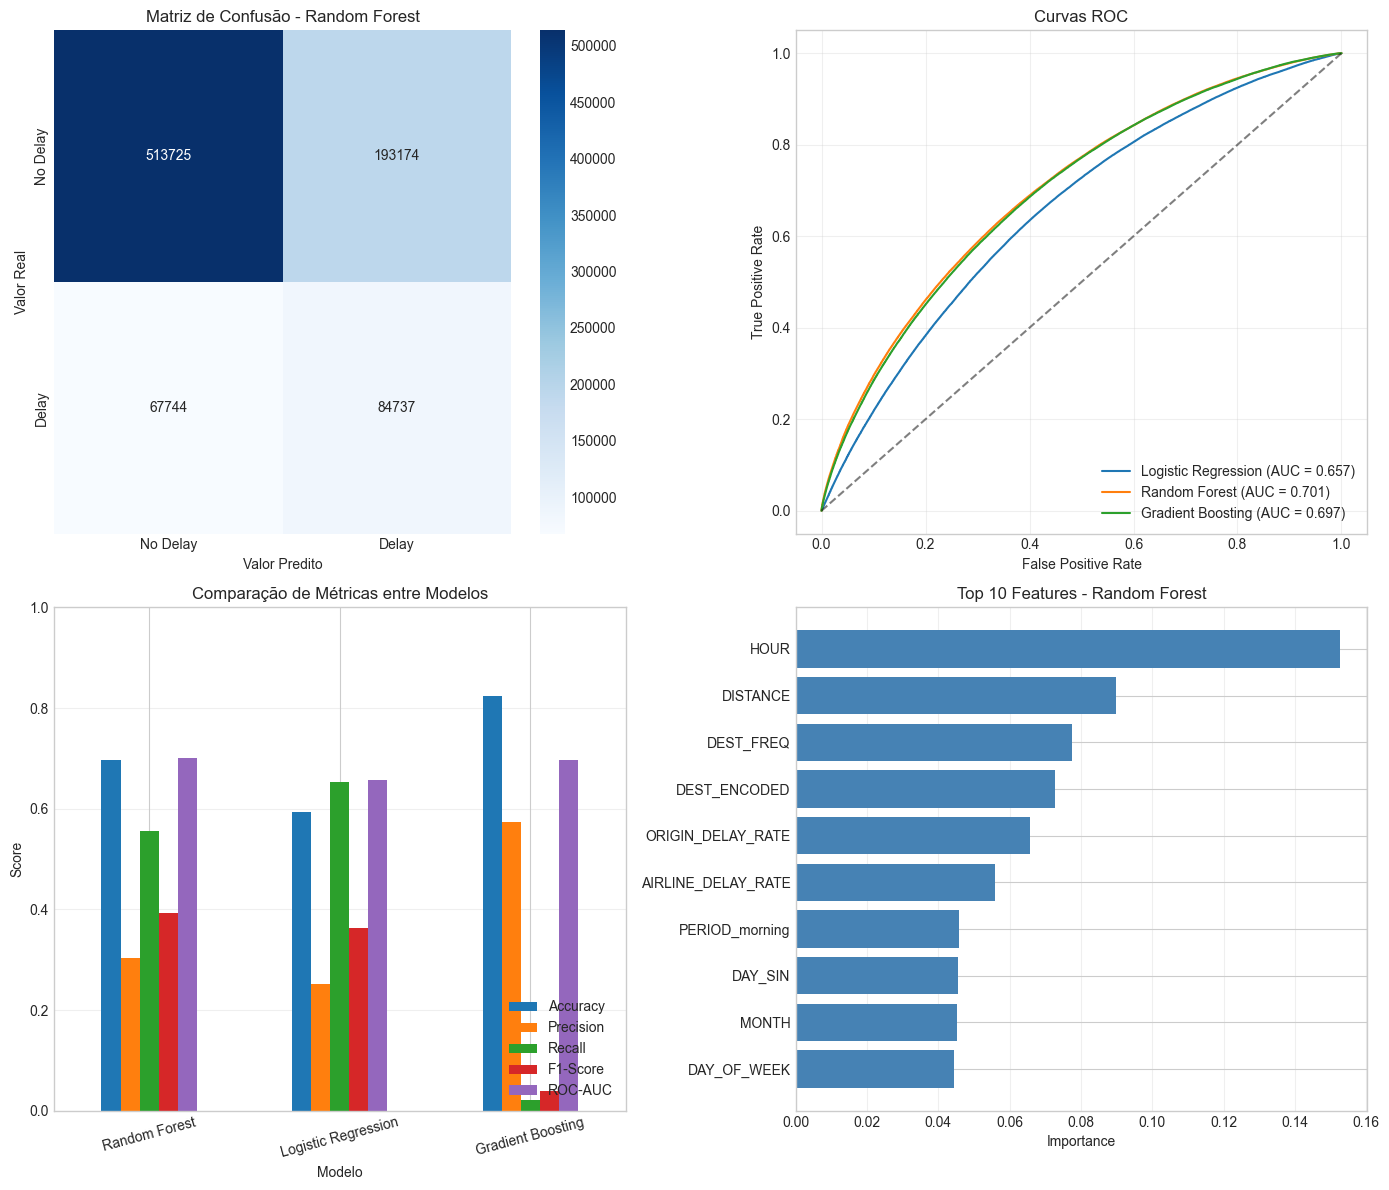


Visualizações salvas em 'visualizacoes/classification_results.png'


In [23]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Matriz de Confusão
ax1 = axes[0, 0]
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['No Delay', 'Delay'],
            yticklabels=['No Delay', 'Delay'])
ax1.set_title(f'Matriz de Confusão - {best_model_name}', fontsize=12)
ax1.set_ylabel('Valor Real')
ax1.set_xlabel('Valor Predito')

# 2. Curvas ROC
ax2 = axes[0, 1]
for name, model in models.items():
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    ax2.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')

ax2.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Curvas ROC', fontsize=12)
ax2.legend(loc='lower right')
ax2.grid(True, alpha=0.3)

# 3. Comparação de Métricas
ax3 = axes[1, 0]
metrics_plot = comparison.set_index('Modelo')[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']]
metrics_plot.plot(kind='bar', ax=ax3, rot=15)
ax3.set_title('Comparação de Métricas entre Modelos', fontsize=12)
ax3.set_ylabel('Score')
ax3.set_ylim([0, 1])
ax3.legend(loc='lower right')
ax3.grid(True, alpha=0.3, axis='y')

# 4. Feature Importance (se disponível)
ax4 = axes[1, 1]
if hasattr(best_model, 'feature_importances_'):
    importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=True).tail(10)
    
    ax4.barh(importance['Feature'], importance['Importance'], color='steelblue')
    ax4.set_title(f'Top 10 Features - {best_model_name}', fontsize=12)
    ax4.set_xlabel('Importance')
else:
    # Para Logistic Regression, usar coeficientes
    coef = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': np.abs(best_model.coef_[0])
    }).sort_values('Coefficient', ascending=True).tail(10)
    
    ax4.barh(coef['Feature'], coef['Coefficient'], color='steelblue')
    ax4.set_title(f'Top 10 Features (|Coeficiente|) - {best_model_name}', fontsize=12)
    ax4.set_xlabel('|Coefficient|')

ax4.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('visualizacoes/classification_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nVisualizações salvas em 'visualizacoes/classification_results.png'")

## 12. Resumo e Conclusões

In [24]:
print("="*80)
print("RESUMO - MODELO DE CLASSIFICAÇÃO")
print("="*80)

print(f"\n1. OBJETIVO:")
print(f"   Prever se um voo terá atraso > 15 minutos na partida")

print(f"\n2. DADOS:")
print(f"   - Total de registros: {len(df):,}")
print(f"   - Features utilizadas: {X.shape[1]}")
print(f"   - Taxa de atraso (classe 1): {y.mean()*100:.2f}%")

print(f"\n3. MODELOS AVALIADOS:")
for _, row in comparison.iterrows():
    print(f"   - {row['Modelo']}: F1={row['F1-Score']:.4f}, ROC-AUC={row['ROC-AUC']:.4f}")

print(f"\n4. MELHOR MODELO: {best_model_name}")
print(f"   - Accuracy:  {accuracy_score(y_test, y_test_pred):.4f}")
print(f"   - Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"   - Recall:    {recall_score(y_test, y_test_pred):.4f}")
print(f"   - F1-Score:  {f1_score(y_test, y_test_pred):.4f}")
print(f"   - ROC-AUC:   {roc_auc_score(y_test, y_test_pred_proba):.4f}")

print(f"\n5. PRINCIPAIS FEATURES:")
if hasattr(best_model, 'feature_importances_'):
    importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False).head(5)
    for i, row in importance.iterrows():
        print(f"   - {row['Feature']}: {row['Importance']:.4f}")

print("\n" + "="*80)

RESUMO - MODELO DE CLASSIFICAÇÃO

1. OBJETIVO:
   Prever se um voo terá atraso > 15 minutos na partida

2. DADOS:
   - Total de registros: 5,729,195
   - Features utilizadas: 20
   - Taxa de atraso (classe 1): 17.74%

3. MODELOS AVALIADOS:
   - Random Forest: F1=0.3933, ROC-AUC=0.7003
   - Logistic Regression: F1=0.3637, ROC-AUC=0.6575
   - Gradient Boosting: F1=0.0399, ROC-AUC=0.6978

4. MELHOR MODELO: Random Forest
   - Accuracy:  0.6964
   - Precision: 0.3049
   - Recall:    0.5557
   - F1-Score:  0.3938
   - ROC-AUC:   0.7012

5. PRINCIPAIS FEATURES:
   - HOUR: 0.1527
   - DISTANCE: 0.0898
   - DEST_FREQ: 0.0774
   - DEST_ENCODED: 0.0727
   - ORIGIN_DELAY_RATE: 0.0658

